# Demo Notebook
This notebook is to demonstrate the different classes and functions in the ipp_library.py file found in this repository. 

In [1]:
# Imports
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn import mixture
from IPython.display import display
from scipy.stats import multivariate_normal
import numpy as np
import scipy as sp
import math
import os
import GPy as GPy
import dubins
import time
from itertools import chain

In [2]:
from ipp_library import *

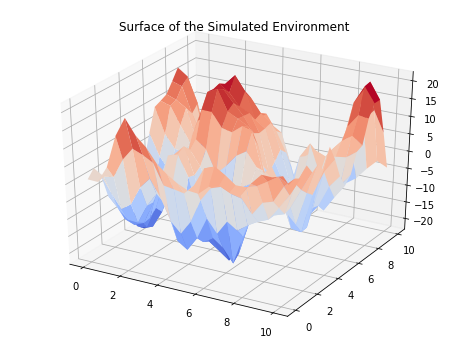

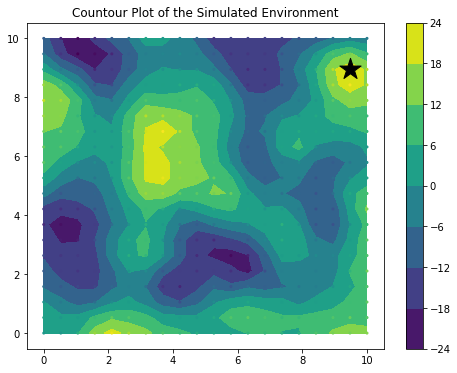

Environment initialized with bounds X1: ( 0.0 , 10.0 )  X2:( 0.0 , 10.0 )


 ipp_library.py:469: RuntimeWarning:divide by zero encountered in log
 ipp_library.py:469: RuntimeWarning:invalid value encountered in sqrt
 ipp_library.py:469: RuntimeWarning:invalid value encountered in double_scalars
 ipp_library.py:469: RuntimeWarning:divide by zero encountered in double_scalars


Number of rollouts: 7597 	 Size of tree: 12739
Number of rollouts: 3907 	 Size of tree: 3727
Number of rollouts: 4029 	 Size of tree: 3734
Number of rollouts: 4065 	 Size of tree: 3971
Number of rollouts: 3918 	 Size of tree: 3670


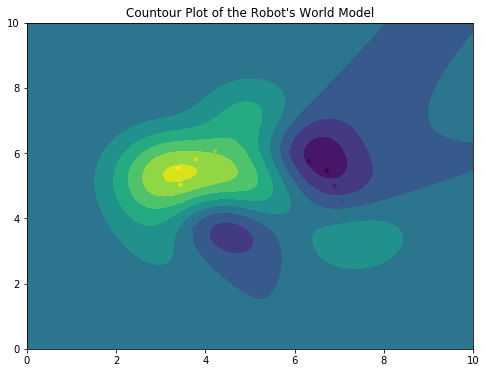

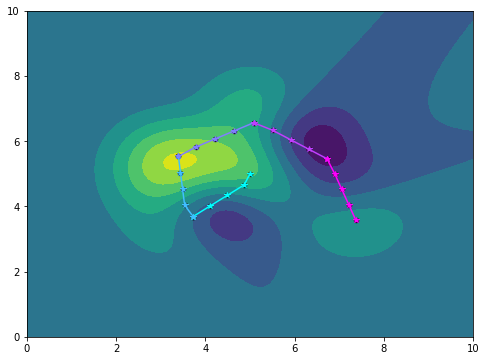

 ipp_library.py:995: RuntimeWarning:invalid value encountered in divide


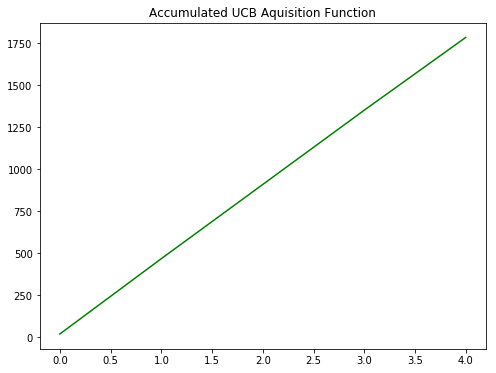

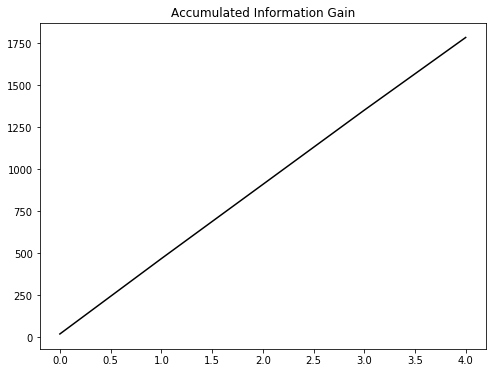

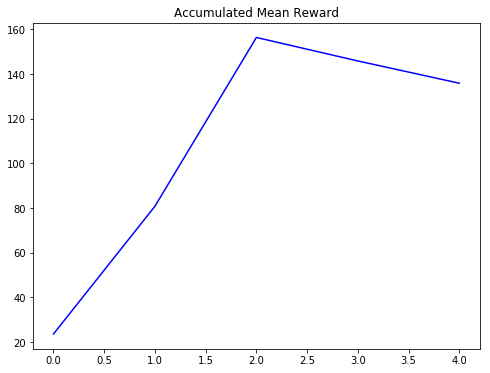

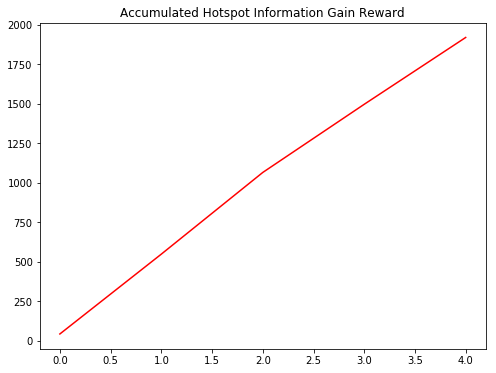

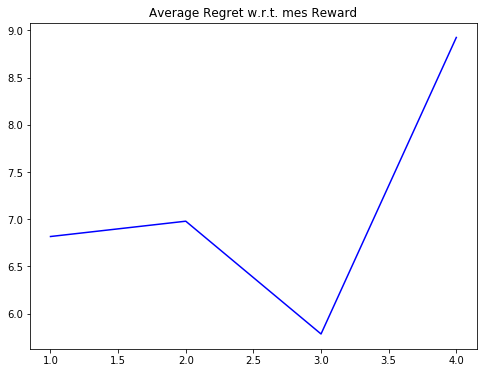

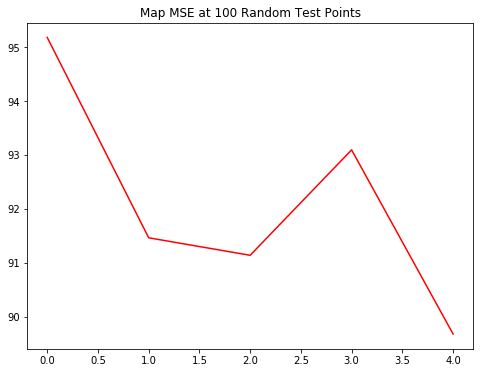

In [3]:
# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS
''' Options include mean, info_gain, hotspot_info, and mes'''
reward_function = 'mes'
ranges = (0., 10., 0., 10.)

world = Environment(ranges = ranges, # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = 100.0, 
                    lengthscale = 1.0, 
                    visualize = True,
                    seed = 8)

evaluation = Evaluation(world = world, 
                        reward_function = reward_function)

# Gather some prior observations to train the kernel (optional)
x1observe = np.linspace(ranges[0]+0.5, ranges[1]-0,5, 5)
x2observe = np.linspace(ranges[2]+0.5, ranges[3]-0.5, 5)
x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
observations = world.sample_value(data)

# Create the point robot
robot = Nonmyopic_Robot(sample_world = world.sample_value, 
              start_loc = (5.0, 5.0, 0.0), 
              extent = ranges,
              kernel_file = None,
              kernel_dataset = None,
              prior_dataset =  None, 
              #prior_dataset =  (data, observations), 
              init_lengthscale = 1.0, 
              init_variance = 100.0, 
              noise = 0.0001,
              path_generator = 'dubins',
              frontier_size = 20, 
              horizon_length = 2.0, 
              turning_radius = 0.1, 
              sample_step = 0.5,
              evaluation = evaluation, 
              f_rew = reward_function, 
              create_animation = False,
              computation_budget = 5.0,
              rollout_length = 3) 

robot.planner(T = 5)
robot.visualize_world_model(screen = True)
robot.visualize_trajectory(screen = True)
robot.plot_information()